#### Importing packages

In [1]:
import pandas as pd
import numpy as np
from scripts.utils import tokenize_sentence, lemmatize_sentence, save_as_pickle, plotConfusionMatrixHeatmap
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Preprocessing & Model Preparation
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Performance Evaluation
from sklearn.metrics import confusion_matrix, classification_report

#### Loading data set

In [2]:
# loading data into pandas dataframe
file_location = '../../data/support_ticket.csv'

tickets_df= pd.read_csv(file_location)

In [3]:
# Shape of the dataframe
tickets_df.shape

(579621, 12)

In [5]:
# Columns in the dataframe
tickets_df.columns

Index(['Unnamed: 0', 'full_text', 'submitted_via', 'sub_label', 'label',
       'word_count', 'unique_word_count', 'stop_word_count', 'url_count',
       'mean_word_length', 'char_count', 'punctuation_count'],
      dtype='object')

#### Preprocessing the data

In [6]:
# Tokenize the ful_text column
tickets_df['full_text_tokenized'] = tickets_df.apply(lambda row : tokenize_sentence(row['full_text']), axis = 1)

In [7]:
# Lemmatize the tokenized column
tickets_df['full_text_lemmatized'] = tickets_df.apply(lambda row : lemmatize_sentence(row['full_text_tokenized']), axis = 1)

In [8]:
tickets_df.sample()

,Unnamed: 0,full_text,submitted_via,sub_label,label,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count,full_text_tokenized,full_text_lemmatized
29950,72248,I have had the private student loan accounts s...,Web,Private student loan,Student loan,132,93,71,0,4.280303,704,14,"[private, student, loan, accounts, serviced, n...",private student loan account serviced navient ...


#### Save processed data onto pickle file

In [11]:
# Saving preprocessed data into pkl file for future processing
save_as_pickle('data_processed.pkl', '../../data/', tickets_df)

'failed'

In [3]:
import os

In [ ]:
pickled_file_loc = os.path.join('../../data/', 'data_processed.pkl')
tickets_df.to_pickle(pickled_file_loc)

#### Load Pickel file

In [3]:
# Loading PKL file as pandas dataframe
df = pd.read_pickle(os.path.join('../../data/', 'data_processed.pkl'))

In [4]:
df.shape

(579621, 14)

#### Encoding the label

In [4]:
# Encodeing label into numerical category
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# https://towardsdatascience.com/categorical-encoding-using-label-encoding-and-one-hot-encoder-911ef77fb5bd
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [6]:
df['label_id'] = label_encoder.fit_transform(df['label'])

In [7]:
# Put the label category into dict for future use
label_map = df.set_index('label_id').to_dict()['label']
label_map

{7: 'Debt collection',
 6: 'Credit reporting, credit repair services, or other personal consumer reports',
 4: 'Credit card or prepaid card',
 1: 'Checking or savings account',
 8: 'Money transfer, virtual currency, or money service',
 16: 'Vehicle loan or lease',
 10: 'Mortgage',
 15: 'Student loan',
 3: 'Credit card',
 13: 'Payday loan, title loan, or personal loan',
 2: 'Consumer Loan',
 12: 'Payday loan',
 5: 'Credit reporting',
 11: 'Other financial service',
 0: 'Bank account or service',
 9: 'Money transfers',
 14: 'Prepaid card',
 17: 'Virtual currency'}

#### Split data into validation/train/test

In [8]:
validation_data = df.sample(frac=0.20)

In [9]:
df.drop(validation_data.index, inplace=True)

In [10]:
print(validation_data.shape)

(115924, 15)


In [11]:
print(df.shape)

(463697, 15)


In [12]:
print(df.columns)

Index(['Unnamed: 0', 'full_text', 'submitted_via', 'sub_label', 'label',
       'word_count', 'unique_word_count', 'stop_word_count', 'url_count',
       'mean_word_length', 'char_count', 'punctuation_count',
       'full_text_tokenized', 'full_text_lemmatized', 'label_id'],
      dtype='object')


In [13]:
# Select X & y data from dataframe
X = df['full_text_lemmatized']
y = df['label_id']

In [14]:
# Split train test data with 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [15]:
# Check how many observation on each categories
y_train.groupby(y_train).count()

label_id
0       9449
1      17185
2       6042
3      11993
4      28911
5      19177
6     113145
7      79164
8       7377
9        954
10     45341
11       177
12      1117
13      5401
14       922
15     17491
16      7103
17         8
Name: label_id, dtype: int64

#### Visualize the train test data

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

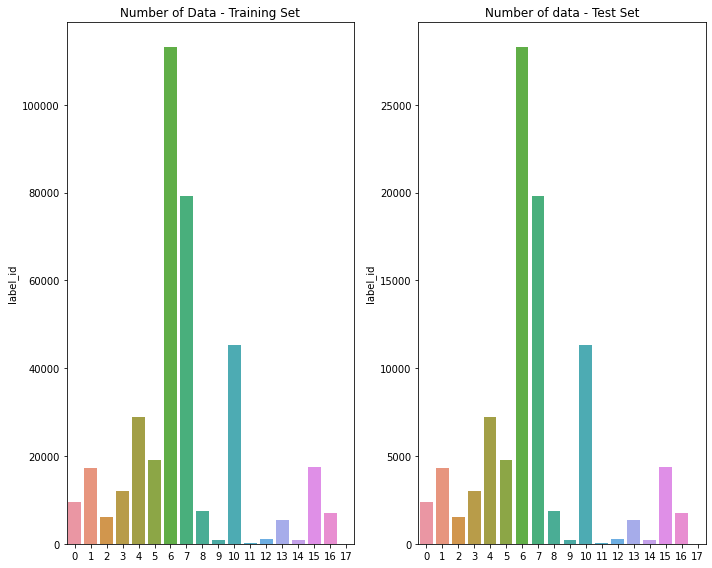

In [17]:
# Plot the observation to visualize
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
sns.barplot(x=sorted(y_train.unique()), y=y_train.groupby(y_train).count(), ax=ax1).set_title('Number of Data - Training Set')
sns.barplot(x=sorted(y_test.unique()), y=y_test.groupby(y_test).count(), ax=ax2).set_title('Number of data - Test Set')
fig.tight_layout()
plt.show()

#### Method 1: Multinomial Naive Bayes Model

In [6]:
# https://towardsdatascience.com/multinomial-naive-bayes-classifier-for-text-analysis-python-8dd6825ece67
# https://www.freecodecamp.org/news/how-to-extract-keywords-from-text-with-tf-idf-and-pythons-scikit-learn-b2a0f3d7e667/
# https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76
from sklearn.naive_bayes import MultinomialNB

In [7]:
# Creating pipeline for Naive Bayes Model
pipeline_mnb = Pipeline(steps = [('TfIdf', TfidfVectorizer()),
                              ('MultinomialNB', MultinomialNB())])

In [20]:
# Parameter values to test
param_grid = {
 'TfIdf__max_features' : [5000, 6000, 7000],
 'TfIdf__ngram_range' : [(1,1)],
 'TfIdf__use_idf' : [True],
 'MultinomialNB__alpha' : [0.01, 0.02, 0.05, 0.10]
}

In [21]:
grid_search_mnb = GridSearchCV(pipeline_mnb, param_grid, cv=5, verbose=1, n_jobs=6)

In [22]:
grid_search_mnb.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  6.2min
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed: 11.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('TfIdf', TfidfVectorizer()),
                                       ('MultinomialNB', MultinomialNB())]),
             n_jobs=6,
             param_grid={'MultinomialNB__alpha': [0.01, 0.02, 0.05, 0.1],
                         'TfIdf__max_features': [5000, 6000, 7000],
                         'TfIdf__ngram_range': [(1, 1)],
                         'TfIdf__use_idf': [True]},
             verbose=1)

In [23]:
print(grid_search_mnb.best_params_)

{'MultinomialNB__alpha': 0.02, 'TfIdf__max_features': 7000, 'TfIdf__ngram_range': (1, 1), 'TfIdf__use_idf': True}


In [24]:
print(grid_search_mnb.best_estimator_)

Pipeline(steps=[('TfIdf', TfidfVectorizer(max_features=7000)),
                ('MultinomialNB', MultinomialNB(alpha=0.02))])


In [25]:
grid_search_mnb.score(X_test, y_test)

0.709359499676515

In [30]:
import pickle

In [27]:
f = open('../../data/mnb_all_cat.pickle', 'wb')
pickle.dump(grid_search_mnb, f)
f.close()

In [28]:
f = open('../../data/mnb_all_cat.pickle', 'rb')
classifier = pickle.load(f)
f.close()

In [29]:
predicted = classifier.predict(X)
df['Predicted_Category_MNB'] = predicted

In [30]:
y_predicted = classifier.predict(X_test)

In [31]:
key_to_label_name = [x[1] for x in sorted(label_map.items())]

In [32]:
from collections import Counter
print(Counter(y_train))
print(Counter(y_test))

Counter({6: 113145, 7: 79164, 10: 45341, 4: 28911, 5: 19177, 15: 17491, 1: 17185, 3: 11993, 0: 9449, 8: 7377, 16: 7103, 2: 6042, 13: 5401, 12: 1117, 9: 954, 14: 922, 11: 177, 17: 8})
Counter({6: 28286, 7: 19791, 10: 11335, 4: 7228, 5: 4794, 15: 4373, 1: 4296, 3: 2998, 0: 2362, 8: 1845, 16: 1776, 2: 1511, 13: 1351, 12: 279, 9: 238, 14: 231, 11: 44, 17: 2})


In [33]:
classification_report_mnb = classification_report(y_test, y_predicted, target_names=key_to_label_name)
print(classification_report_mnb)

e:\springboard\works\support_ticket_label_classification\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.70      0.15      0.25      2362
                                                 Checking or savings account       0.58      0.71      0.63      4296
                                                               Consumer Loan       0.47      0.09      0.14      1511
                                                                 Credit card       0.72      0.07      0.13      2998
                                                 Credit card or prepaid card       0.54      0.75      0.63      7228
                                                            Credit reporting       0.68      0.03      0.05      4794
Credit reporting, credit repair services, or other personal consumer reports       0.69      0.86      0.77     28286
                                                       

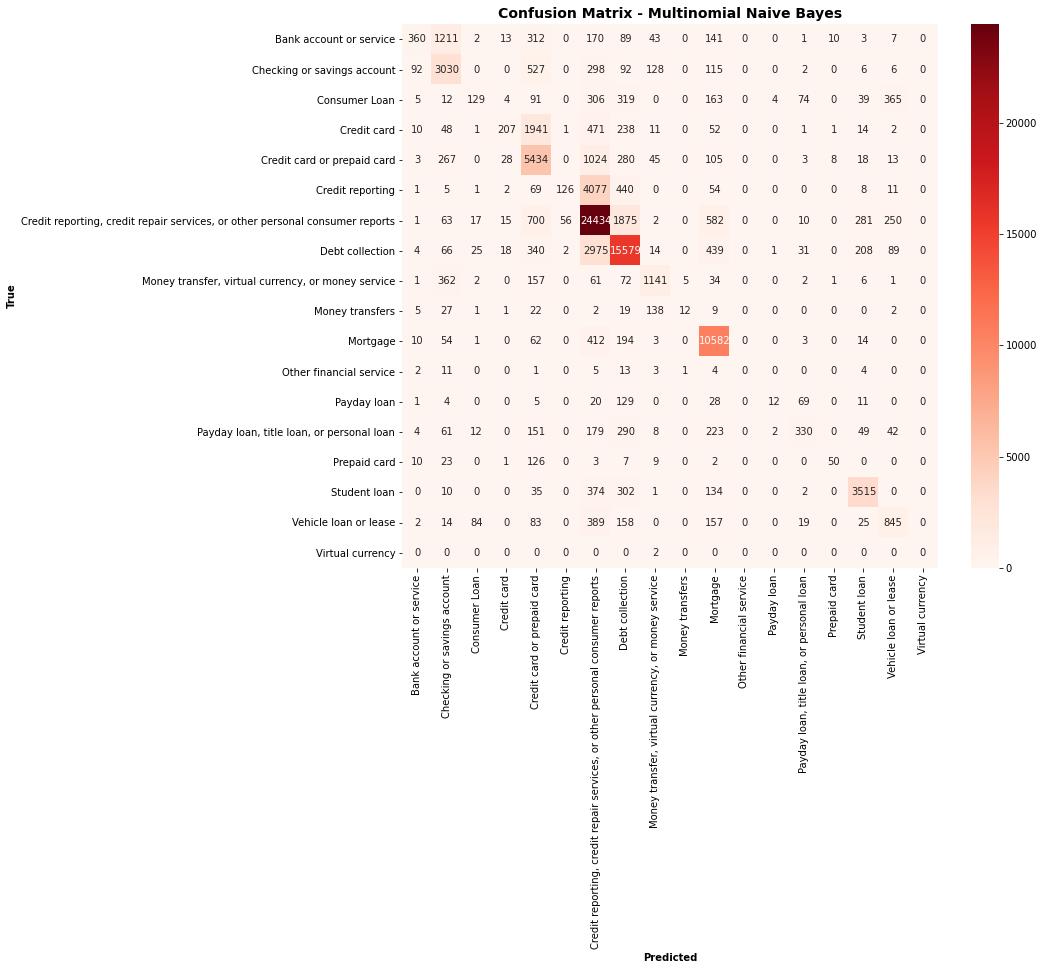

In [34]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Multinomial Naive Bayes', figsize=(12, 10))

In [40]:
X_validation = validation_data['full_text_lemmatized']
y_validation = validation_data['label_id']

In [44]:
y_predicted_val = classifier.predict(X_validation)

In [45]:
classification_report_mnb = classification_report(y_validation, y_predicted_val, target_names=key_to_label_name)
print(classification_report_mnb)

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.73      0.17      0.27      3060
                                                 Checking or savings account       0.56      0.71      0.62      5234
                                                               Consumer Loan       0.45      0.09      0.15      1891
                                                                 Credit card       0.66      0.06      0.11      3766
                                                 Credit card or prepaid card       0.54      0.75      0.63      9039
                                                            Credit reporting       0.69      0.03      0.05      5965
Credit reporting, credit repair services, or other personal consumer reports       0.69      0.87      0.77     35431
                                                       

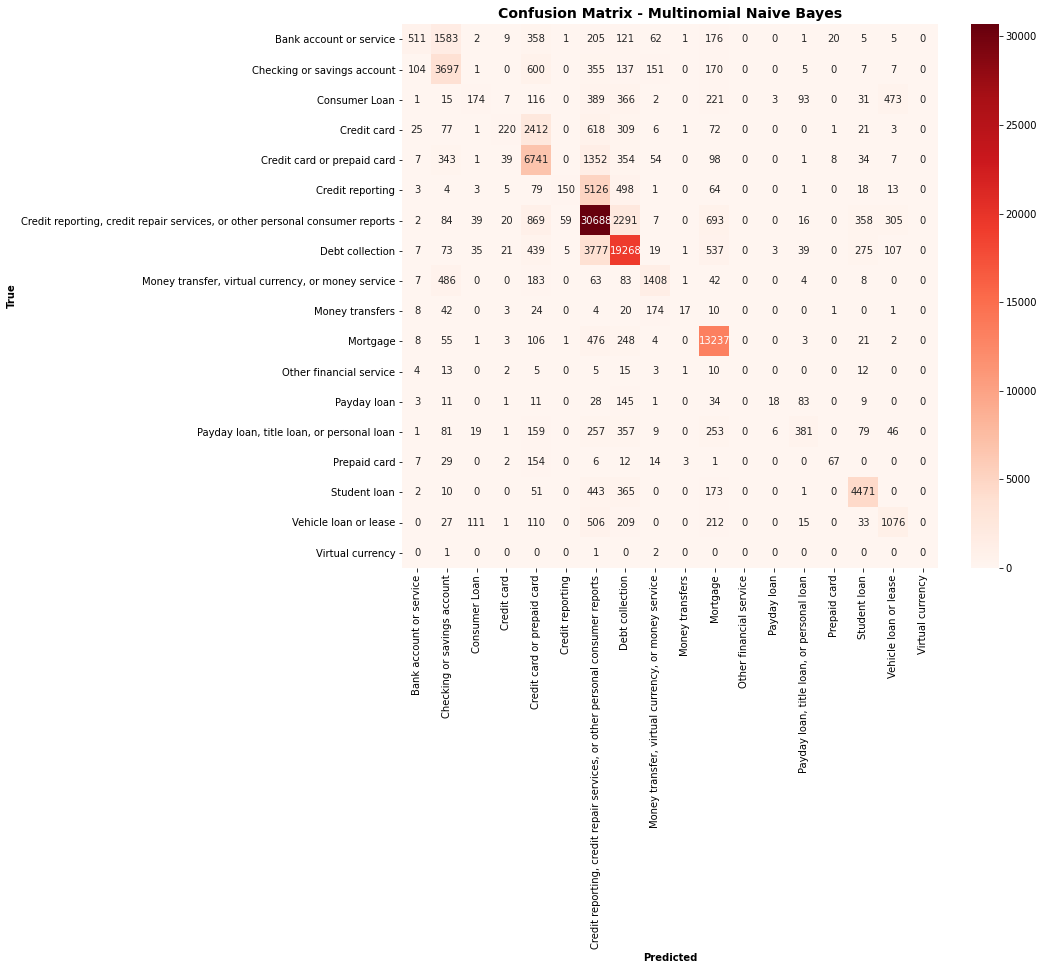

In [46]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_validation, y_predicted_val),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Multinomial Naive Bayes', figsize=(12, 10))

#### Method 2 : Linear support vector machine with SGDClassifier

In [24]:
from sklearn.linear_model import SGDClassifier

In [25]:
# https://michael-fuchs-python.netlify.app/2019/11/11/introduction-to-sgd-classifier/
pipeline_lsvm = Pipeline(steps= [('TfIdf', TfidfVectorizer()),
                                 ('SGDC', SGDClassifier(verbose=1, random_state=42))])

In [46]:
# Parameter values to test
param_grid = {
 'TfIdf__max_features' : [None, 200, 300, 400],
 'TfIdf__ngram_range' : [(1,1)],
 'TfIdf__use_idf' : [True],
 'SGDC__loss' : ['hinge'],
 'SGDC__alpha' : [0.001, 0.01, 0.05, 0.1]
}

In [47]:
grid_search_svc = GridSearchCV(pipeline_lsvm, param_grid, cv=10, verbose=1, n_jobs=6)

In [48]:
grid_search_svc.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


e:\springboard\works\support_ticket_label_classification\venv\lib\site-packages\sklearn\model_selection\_split.py:670: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 14.1min
[Parallel(n_jobs=6)]: Done 160 out of 160 | elapsed: 55.4min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 0.34, NNZs: 25097, Bias: -1.006020, T: 370957, Avg. loss: 0.051431
Total training time: 0.27 seconds.
-- Epoch 2
Norm: 0.31, NNZs: 27834, Bias: -1.003679, T: 741914, Avg. loss: 0.051208
Total training time: 0.49 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 29090, Bias: -1.003000, T: 1112871, Avg. loss: 0.051195
Total training time: 0.70 seconds.
-- Epoch 4
Norm: 0.29, NNZs: 29828, Bias: -1.002418, T: 1483828, Avg. loss: 0.051189
Total training time: 0.92 seconds.
-- Epoch 5
Norm: 0.28, NNZs: 30251, Bias: -1.002267, T: 1854785, Avg. loss: 0.051187
Total training time: 1.14 seconds.
-- Epoch 6
Norm: 0.28, NNZs: 30557, Bias: -1.002100, T: 2225742, Avg. loss: 0.051185
Total training time: 1.37 seconds.
Convergence after 6 epochs took 1.37 seconds
-- Epoch 1
Norm: 1.20, NNZs: 31615, Bias: -1.049645, T: 370957, Avg. loss: 0.090838
Total training time: 0.22 seconds.
-- Epoch 2
Norm: 1.16, NNZs: 32643, Bias: -1.046491, T: 741914, Avg. loss: 0.090667
Total training time: 0.43 seconds.

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   26.2s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('TfIdf', TfidfVectorizer()),
                                       ('SGDC',
                                        SGDClassifier(random_state=42,
                                                      verbose=1))]),
             n_jobs=6,
             param_grid={'SGDC__alpha': [0.001, 0.01, 0.05, 0.1],
                         'SGDC__loss': ['hinge'],
                         'TfIdf__max_features': [None, 200, 300, 400],
                         'TfIdf__ngram_range': [(1, 1)],
                         'TfIdf__use_idf': [True]},
             verbose=1)

In [49]:
print(grid_search_svc.best_params_)

{'SGDC__alpha': 0.001, 'SGDC__loss': 'hinge', 'TfIdf__max_features': None, 'TfIdf__ngram_range': (1, 1), 'TfIdf__use_idf': True}


In [50]:
# Check the score on the training and test sets
grid_search_svc.score(X_test, y_test)

0.6812917834806987

In [51]:
predicted = grid_search_svc.predict(X)
df['Predicted_Category_LSVM'] = predicted

In [52]:
y_predicted = grid_search_svc.predict(X_test)

In [53]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),index=key_to_label_name,
                              columns=key_to_label_name)

In [54]:
classification_rep = classification_report(y_test, y_predicted,target_names=key_to_label_name)
print(classification_rep)

                                                                              precision    recall  f1-score   support

                                                     Bank account or service       0.66      0.05      0.09      2376
                                                 Checking or savings account       0.58      0.56      0.57      4261
                                                               Consumer Loan       0.45      0.02      0.03      1512
                                                                 Credit card       0.53      0.01      0.02      2987
                                                 Credit card or prepaid card       0.60      0.55      0.57      7255
                                                            Credit reporting       0.00      0.00      0.00      4782
Credit reporting, credit repair services, or other personal consumer reports       0.66      0.88      0.75     28302
                                                       

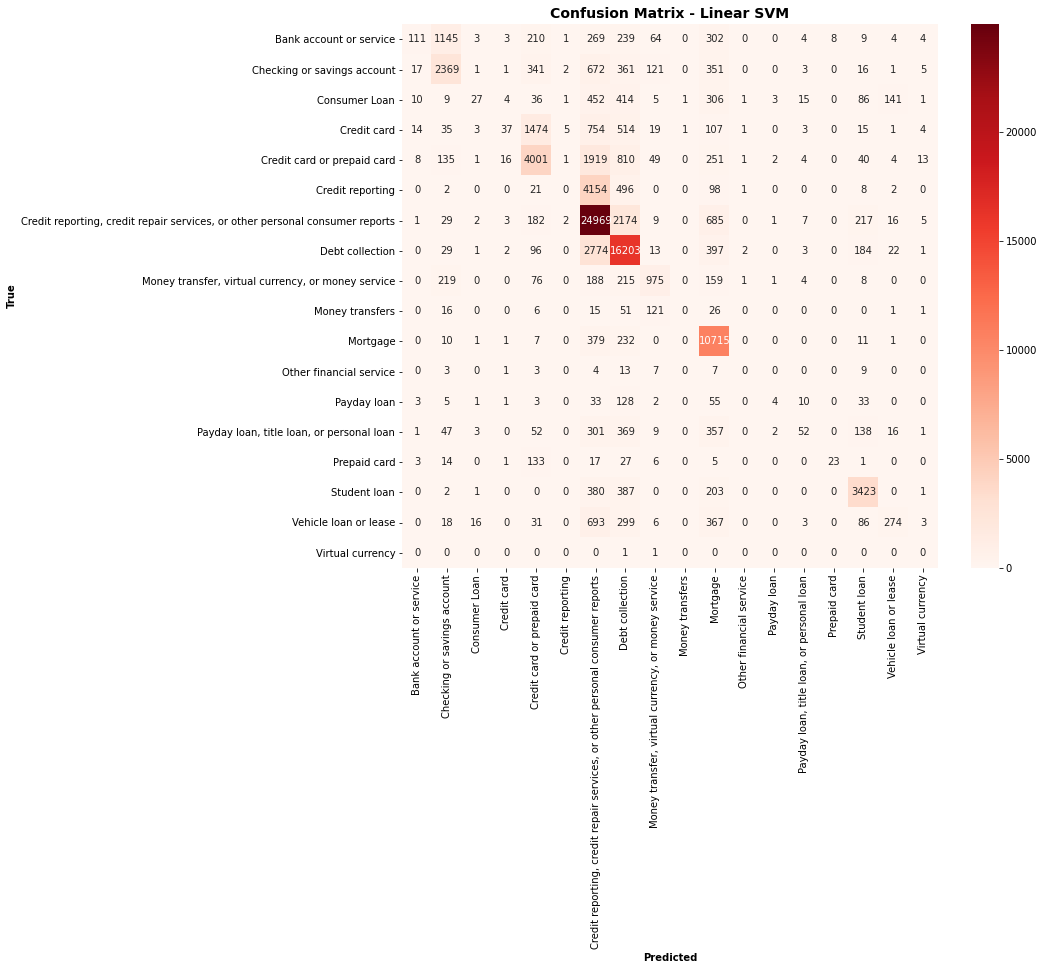

In [55]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Linear SVM', figsize=(12, 10))

#### Optimize Label Categories

In [8]:
df_optimize = pd.read_pickle(os.path.join('../../data/', 'data_processed.pkl'))

In [9]:
df_optimize['label'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    176862
Debt collection                                                                 123561
Mortgage                                                                         70841
Credit card or prepaid card                                                      45178
Credit reporting                                                                 29936
Student loan                                                                     27380
Checking or savings account                                                      26715
Credit card                                                                      18757
Bank account or service                                                          14871
Money transfer, virtual currency, or money service                               11507
Vehicle loan or lease                                                            11179
Consumer Loan                              

In [37]:
label_category_map = {'Credit reporting, credit repair services, or other personal consumer reports': 'Credit reporting',
                      'Credit card': 'Credit card or prepaid card',
                      'Payday loan': 'Payday loan, title loan, or personal loan',
                      'Prepaid card': 'Credit card or prepaid card',
                      'Money transfers': 'Money transfer, virtual currency, or money service',
                      'Virtual currency': 'Money transfer, virtual currency, or money service'}

In [38]:
df_optimize['label'].replace(label_category_map, inplace=True)

In [39]:
df_optimize['label'].value_counts()

Credit reporting                                      206798
Debt collection                                       123561
Mortgage                                               70841
Credit card or prepaid card                            65383
Student loan                                           27380
Checking or savings account                            26715
Bank account or service                                14871
Money transfer, virtual currency, or money service     13017
Vehicle loan or lease                                  11179
Payday loan, title loan, or personal loan              10141
Consumer Loan                                           9444
Other financial service                                  291
Name: label, dtype: int64

In [47]:
validation_data_optimize = df_optimize.sample(frac=0.20)

In [67]:
validation_data_optimize['label_id'] = label_encoder.fit_transform(validation_data_optimize['label'])

In [48]:
df_optimize.drop(validation_data_optimize.index, inplace=True)

In [49]:
df_optimize['label_id'] = label_encoder.fit_transform(df_optimize['label'])

In [50]:
# Put the label category into dict for future use
label_map = df_optimize.set_index('label_id').to_dict()['label']
label_map

{5: 'Debt collection',
 4: 'Credit reporting',
 3: 'Credit card or prepaid card',
 1: 'Checking or savings account',
 6: 'Money transfer, virtual currency, or money service',
 11: 'Vehicle loan or lease',
 7: 'Mortgage',
 10: 'Student loan',
 9: 'Payday loan, title loan, or personal loan',
 2: 'Consumer Loan',
 8: 'Other financial service',
 0: 'Bank account or service'}

In [51]:
# Select X & y data from dataframe
X = df_optimize['full_text_lemmatized']
y = df_optimize['label_id']

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Method 3 : Multinomial Naive Bayes Model With optimize categories

In [53]:
param_grid = {
 'TfIdf__max_features' : [5000, 6000, 7000],
 'TfIdf__ngram_range' : [(1,1)],
 'TfIdf__use_idf' : [True],
 'MultinomialNB__alpha' : [0.01, 0.02, 0.05, 0.10]
}

In [54]:
grid_search_mnb = GridSearchCV(pipeline_mnb, param_grid, cv=5, verbose=1, n_jobs=6)

In [55]:
grid_search_mnb.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 10.6min
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed: 15.2min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('TfIdf', TfidfVectorizer()),
                                       ('MultinomialNB', MultinomialNB())]),
             n_jobs=6,
             param_grid={'MultinomialNB__alpha': [0.01, 0.02, 0.05, 0.1],
                         'TfIdf__max_features': [5000, 6000, 7000],
                         'TfIdf__ngram_range': [(1, 1)],
                         'TfIdf__use_idf': [True]},
             verbose=1)

In [56]:
print(grid_search_mnb.best_params_)

{'MultinomialNB__alpha': 0.01, 'TfIdf__max_features': 7000, 'TfIdf__ngram_range': (1, 1), 'TfIdf__use_idf': True}


In [57]:
print(grid_search_mnb.best_estimator_)

Pipeline(steps=[('TfIdf', TfidfVectorizer(max_features=7000)),
                ('MultinomialNB', MultinomialNB(alpha=0.01))])


In [58]:
grid_search_mnb.score(X_test, y_test)

0.7761699374595644

In [59]:
f = open('../../data/mnb_optimized_cat_1.pickle', 'wb')
pickle.dump(grid_search_mnb, f)
f.close()

In [60]:
f = open('../../data/mnb_optimized_cat_1.pickle', 'rb')
classifier_optimized = pickle.load(f)
f.close()

In [61]:
predicted = classifier_optimized.predict(X)
df_optimize['Predicted_Category_MNB'] = predicted

In [62]:
y_predicted = classifier_optimized.predict(X_test)

In [63]:
key_to_label_name = [x[1] for x in sorted(label_map.items())]

In [64]:
classification_report_mnb = classification_report(y_test, y_predicted, target_names=key_to_label_name)
print(classification_report_mnb)

e:\springboard\works\support_ticket_label_classification\venv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                                    precision    recall  f1-score   support

                           Bank account or service       0.70      0.13      0.22      2381
                       Checking or savings account       0.60      0.66      0.63      4286
                                     Consumer Loan       0.47      0.07      0.12      1511
                       Credit card or prepaid card       0.69      0.79      0.74     10454
                                  Credit reporting       0.80      0.87      0.84     33082
                                   Debt collection       0.80      0.76      0.78     19777
Money transfer, virtual currency, or money service       0.82      0.64      0.72      2071
                                          Mortgage       0.84      0.92      0.88     11325
                           Other financial service       0.00      0.00      0.00        46
         Payday loan, title loan, or personal loan       0.71      0.26      0.

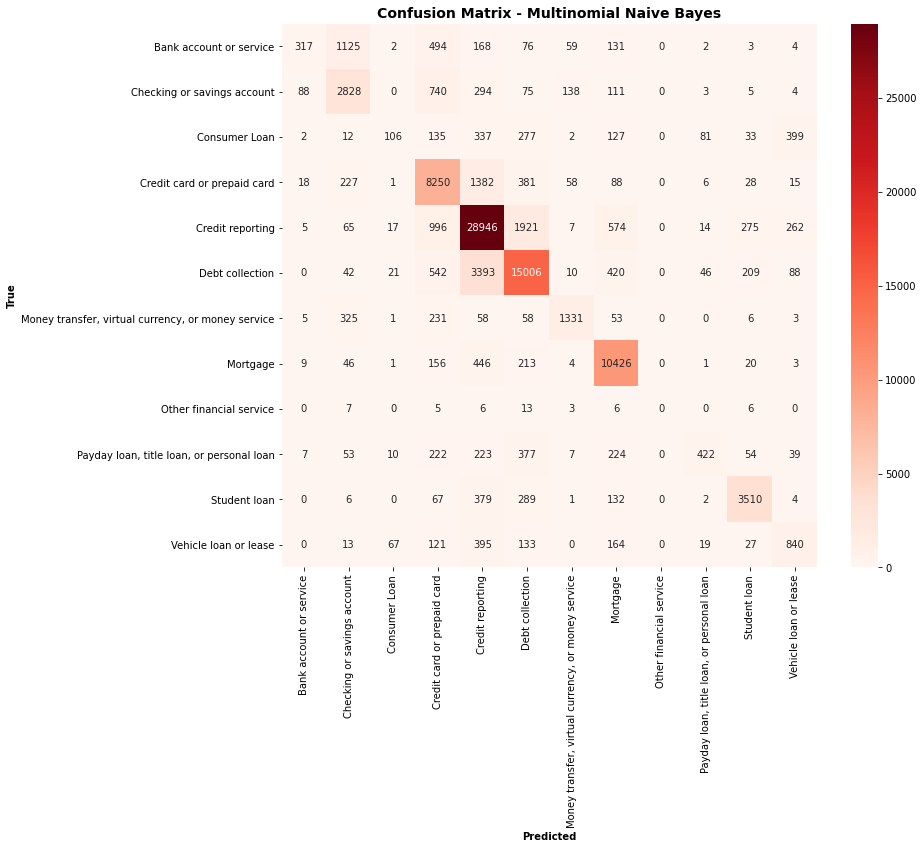

In [65]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Multinomial Naive Bayes', figsize=(12, 10))

In [68]:
X_validation = validation_data_optimize['full_text_lemmatized']
y_validation = validation_data_optimize['label_id']

In [73]:
y_predicted_val = classifier_optimized.predict(X_validation)

In [74]:
classification_report_mnb = classification_report(y_validation, y_predicted_val, target_names=key_to_label_name)
print(classification_report_mnb)

                                                    precision    recall  f1-score   support

                           Bank account or service       0.72      0.15      0.24      2967
                       Checking or savings account       0.59      0.66      0.62      5285
                                     Consumer Loan       0.44      0.08      0.14      1891
                       Credit card or prepaid card       0.69      0.79      0.74     13113
                                  Credit reporting       0.80      0.88      0.84     41390
                                   Debt collection       0.80      0.76      0.78     24674
Money transfer, virtual currency, or money service       0.84      0.62      0.71      2660
                                          Mortgage       0.84      0.93      0.88     14216
                           Other financial service       0.00      0.00      0.00        62
         Payday loan, title loan, or personal loan       0.71      0.26      0.

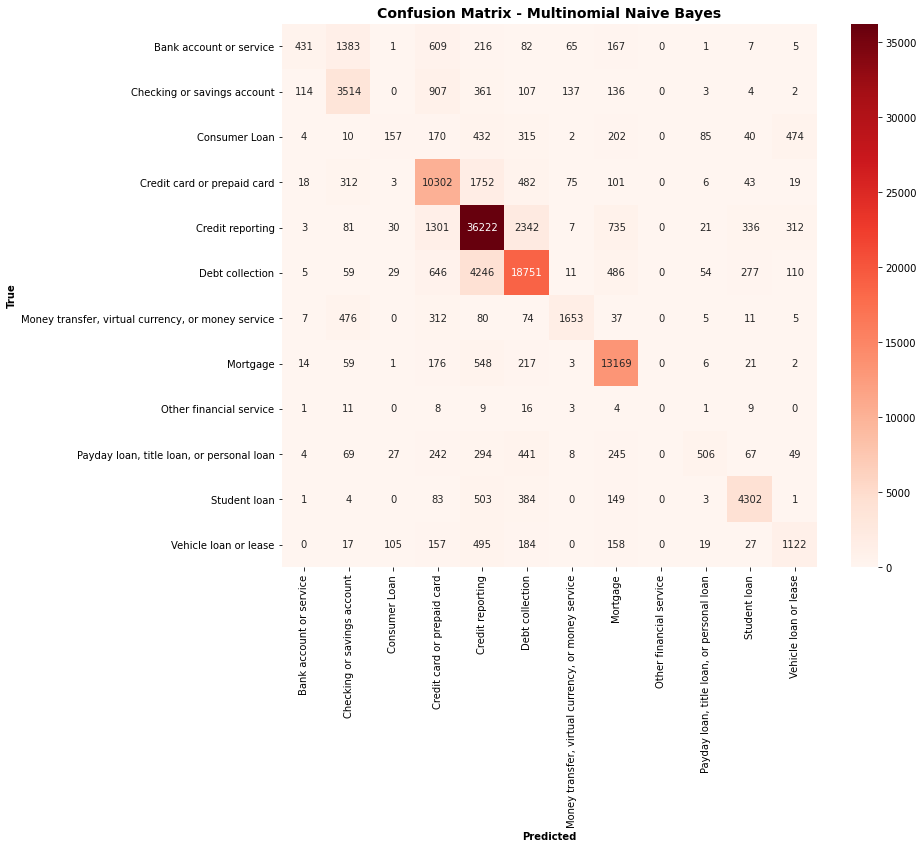

In [75]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_validation, y_predicted_val),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Multinomial Naive Bayes', figsize=(12, 10))

#### method 4 : Linear support vector machine with SGDClassifier optimize categories

In [79]:
param_grid = {
 'TfIdf__max_features' : [None, 200, 300, 400],
 'TfIdf__ngram_range' : [(1,1)],
 'TfIdf__use_idf' : [True],
 'SGDC__loss' : ['hinge'],
 'SGDC__alpha' : [0.001, 0.01, 0.05, 0.1]
}

In [80]:
grid_search_svc = GridSearchCV(pipeline_lsvm, param_grid, cv=10, verbose=1, n_jobs=6)

In [81]:
grid_search_svc.fit(X_train, y_train)

Fitting 10 folds for each of 16 candidates, totalling 160 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  7.3min
[Parallel(n_jobs=6)]: Done 160 out of 160 | elapsed: 28.9min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 0.34, NNZs: 25182, Bias: -1.006117, T: 370957, Avg. loss: 0.051840
Total training time: 0.14 seconds.
-- Epoch 2
Norm: 0.30, NNZs: 27862, Bias: -1.003732, T: 741914, Avg. loss: 0.051609
Total training time: 0.27 seconds.
-- Epoch 3
Norm: 0.29, NNZs: 29095, Bias: -1.002735, T: 1112871, Avg. loss: 0.051597
Total training time: 0.40 seconds.
-- Epoch 4
Norm: 0.28, NNZs: 29848, Bias: -1.002374, T: 1483828, Avg. loss: 0.051592
Total training time: 0.53 seconds.
-- Epoch 5
Norm: 0.28, NNZs: 30264, Bias: -1.002209, T: 1854785, Avg. loss: 0.051589
Total training time: 0.65 seconds.
-- Epoch 6
Norm: 0.27, NNZs: 30645, Bias: -1.001959, T: 2225742, Avg. loss: 0.051588
Total training time: 0.78 seconds.
Convergence after 6 epochs took 0.78 seconds
-- Epoch 1
Norm: 1.21, NNZs: 32218, Bias: -1.056731, T: 370957, Avg. loss: 0.091022
Total training time: 0.13 seconds.
-- Epoch 2
Norm: 1.16, NNZs: 33194, Bias: -1.051099, T: 741914, Avg. loss: 0.090917
Total training time: 0.26 seconds.

[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   10.0s finished


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('TfIdf', TfidfVectorizer()),
                                       ('SGDC',
                                        SGDClassifier(random_state=42,
                                                      verbose=1))]),
             n_jobs=6,
             param_grid={'SGDC__alpha': [0.001, 0.01, 0.05, 0.1],
                         'SGDC__loss': ['hinge'],
                         'TfIdf__max_features': [None, 200, 300, 400],
                         'TfIdf__ngram_range': [(1, 1)],
                         'TfIdf__use_idf': [True]},
             verbose=1)

In [82]:
print(grid_search_svc.best_params_)

{'SGDC__alpha': 0.001, 'SGDC__loss': 'hinge', 'TfIdf__max_features': None, 'TfIdf__ngram_range': (1, 1), 'TfIdf__use_idf': True}


In [83]:
# Check the score on the training and test sets
grid_search_svc.score(X_test, y_test)

0.72895190856157

In [84]:
predicted = grid_search_svc.predict(X)
df_optimize['Predicted_Category_LSVM'] = predicted

In [85]:
y_predicted = grid_search_svc.predict(X_test)

In [86]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),index=key_to_label_name,
                              columns=key_to_label_name)

In [87]:
classification_rep = classification_report(y_test, y_predicted,target_names=key_to_label_name)
print(classification_rep)

                                                    precision    recall  f1-score   support

                           Bank account or service       0.70      0.03      0.06      2395
                       Checking or savings account       0.60      0.54      0.57      4272
                                     Consumer Loan       0.29      0.01      0.02      1519
                       Credit card or prepaid card       0.64      0.54      0.59      7446
                                  Credit reporting       0.74      0.90      0.81     33082
                        Creditcard or prepaid card       0.48      0.01      0.03      2995
                                   Debt collection       0.73      0.79      0.76     19770
Money transfer, virtual currency, or money service       0.73      0.60      0.66      2088
                                          Mortgage       0.76      0.94      0.84     11313
                           Other financial service       0.00      0.00      0.

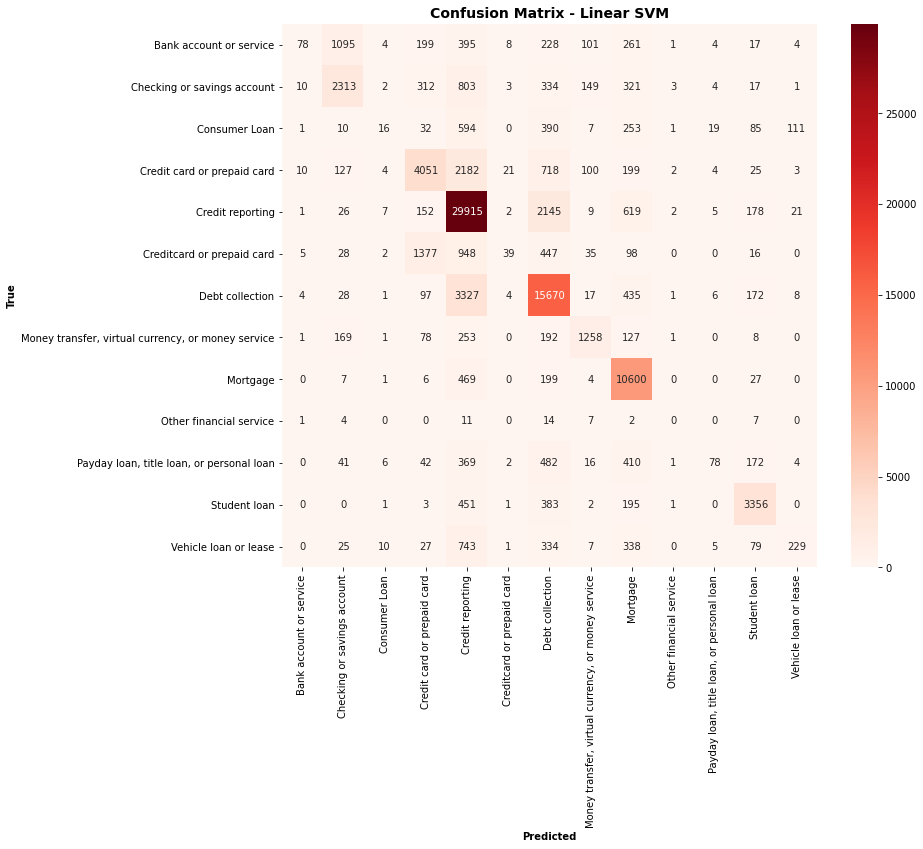

In [88]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_label_name, columns=key_to_label_name)

plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Linear SVM', figsize=(12, 10))

#### Method 5 : Random forest with optimized categories

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer

In [39]:
vectorizer = TfidfVectorizer(min_df=3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [42]:
pipeline_rf = Pipeline(steps = [('TfIdf', vectorizer),
                              ('clf', RandomForestClassifier())])

In [ ]:
model = pipeline_rf.fit(X_train, y_train)

In [ ]:
with open('RandomForest.pickle', 'wb') as f:
    pickle.dump(model, f)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
y_pred_prob = models.predict_proba(X_test)

In [ ]:
lr_probs = y_pred_prob[:,1]

In [ ]:
ac = accuracy_score(y_test, y_pred)

In [ ]:
f1 = f1_score(y_test, y_pred, average='weighted')

In [ ]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_pred),index=key_to_label_name,
                              columns=key_to_label_name)

In [ ]:
classification_rep = classification_report(y_test, y_pred,target_names=key_to_label_name)
print(classification_rep)

In [ ]:
plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Random forest', figsize=(12, 10))

### Loan Section only

In [10]:
df_optimize['label'].value_counts()

Credit reporting, credit repair services, or other personal consumer reports    176862
Debt collection                                                                 123561
Mortgage                                                                         70841
Credit card or prepaid card                                                      45178
Credit reporting                                                                 29936
Student loan                                                                     27380
Checking or savings account                                                      26715
Credit card                                                                      18757
Bank account or service                                                          14871
Money transfer, virtual currency, or money service                               11507
Vehicle loan or lease                                                            11179
Consumer Loan                              

In [12]:
label_category_map = {'Payday loan': 'Payday loan, title loan, or personal loan'}

filter_list = ["Payday loan", "Student loan", 
               "Mortgage", "Vehicle loan or lease", 
               "Consumer Loan", "Payday loan, title loan, or personal loan"]

In [13]:
df_optimize = df_optimize[df_optimize.label.isin(filter_list)]

In [14]:
df_optimize['label'].replace(label_category_map, inplace=True)

In [15]:
df_optimize['label'].value_counts()

Mortgage                                     70841
Student loan                                 27380
Vehicle loan or lease                        11179
Payday loan, title loan, or personal loan    10141
Consumer Loan                                 9444
Name: label, dtype: int64

In [16]:
validation_loan_data = df_optimize.sample(frac=0.20)

In [17]:
validation_loan_data['label_id'] = label_encoder.fit_transform(validation_loan_data['label'])

In [18]:
df_optimize.drop(validation_loan_data.index, inplace=True)

In [19]:
df_optimize['label_id'] = label_encoder.fit_transform(df_optimize['label'])

In [20]:
# Put the label category into dict for future use
label_map = df_optimize.set_index('label_id').to_dict()['label']
label_map

{1: 'Mortgage',
 4: 'Vehicle loan or lease',
 3: 'Student loan',
 2: 'Payday loan, title loan, or personal loan',
 0: 'Consumer Loan'}

In [21]:
# Select X & y data from dataframe
X = df_optimize['full_text_lemmatized']
y = df_optimize['label_id']

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [23]:
param_grid = {
 'TfIdf__max_features' : [5000, 6000, 7000],
 'TfIdf__ngram_range' : [(1,1)],
 'TfIdf__use_idf' : [True],
 'MultinomialNB__alpha' : [0.01, 0.02, 0.05, 0.10]
}

In [24]:
grid_search_mnb = GridSearchCV(pipeline_mnb, param_grid, cv=5, verbose=1, n_jobs=6)

In [25]:
grid_search_mnb.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:  1.8min
[Parallel(n_jobs=6)]: Done  60 out of  60 | elapsed:  2.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('TfIdf', TfidfVectorizer()),
                                       ('MultinomialNB', MultinomialNB())]),
             n_jobs=6,
             param_grid={'MultinomialNB__alpha': [0.01, 0.02, 0.05, 0.1],
                         'TfIdf__max_features': [5000, 6000, 7000],
                         'TfIdf__ngram_range': [(1, 1)],
                         'TfIdf__use_idf': [True]},
             verbose=1)

In [26]:
print(grid_search_mnb.best_params_)

{'MultinomialNB__alpha': 0.01, 'TfIdf__max_features': 7000, 'TfIdf__ngram_range': (1, 1), 'TfIdf__use_idf': True}


In [27]:
print(grid_search_mnb.best_estimator_)

Pipeline(steps=[('TfIdf', TfidfVectorizer(max_features=7000)),
                ('MultinomialNB', MultinomialNB(alpha=0.01))])


In [28]:
grid_search_mnb.score(X_test, y_test)

0.8506638240139548

In [31]:
f = open('../../data/mnb_loan_data.pickle', 'wb')
pickle.dump(grid_search_mnb, f)
f.close()  

In [32]:
f = open('../../data/mnb_loan_data.pickle', 'rb')
loan_classifier = pickle.load(f)
f.close()

In [34]:
predicted = loan_classifier.predict(X)
df_optimize['Predicted_Category_MNB'] = predicted

In [35]:
y_predicted = loan_classifier.predict(X_test)

In [36]:
key_to_label_name = [x[1] for x in sorted(label_map.items())]

In [37]:
classification_report_mnb = classification_report(y_test, y_predicted, target_names=key_to_label_name)
print(classification_report_mnb)

                                           precision    recall  f1-score   support

                            Consumer Loan       0.63      0.23      0.34      1507
                                 Mortgage       0.86      1.00      0.92     11350
Payday loan, title loan, or personal loan       0.77      0.50      0.61      1628
                             Student loan       0.95      0.91      0.93      4369
                    Vehicle loan or lease       0.66      0.63      0.64      1784

                                 accuracy                           0.85     20638
                                macro avg       0.77      0.65      0.69     20638
                             weighted avg       0.84      0.85      0.83     20638



In [38]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_predicted),
                              index=key_to_label_name, columns=key_to_label_name)

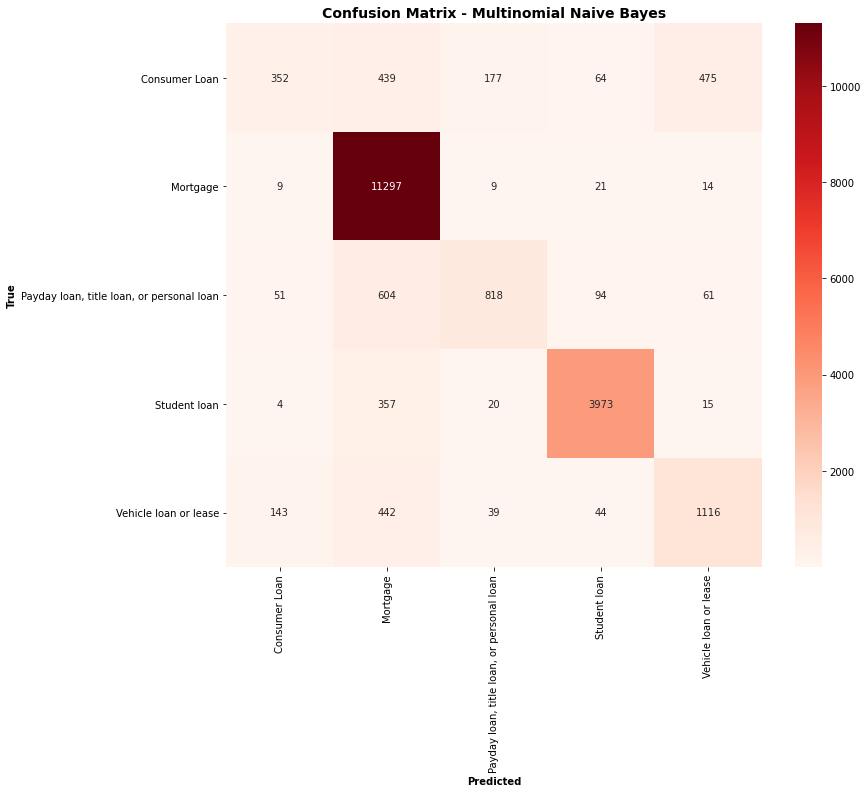

In [39]:
plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Multinomial Naive Bayes', figsize=(12, 10))

#### Validation

In [40]:
X_validation = validation_loan_data['full_text_lemmatized']
y_validation = validation_loan_data['label_id']

In [42]:
y_predicted_val = loan_classifier.predict(X_validation)

In [43]:
classification_report_mnb = classification_report(y_validation, y_predicted_val, target_names=key_to_label_name)
print(classification_report_mnb)

                                           precision    recall  f1-score   support

                            Consumer Loan       0.61      0.23      0.33      1908
                                 Mortgage       0.86      1.00      0.92     14093
Payday loan, title loan, or personal loan       0.76      0.50      0.60      2001
                             Student loan       0.95      0.92      0.93      5534
                    Vehicle loan or lease       0.67      0.63      0.65      2261

                                 accuracy                           0.85     25797
                                macro avg       0.77      0.65      0.69     25797
                             weighted avg       0.84      0.85      0.83     25797



In [44]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_validation, y_predicted_val),
                              index=key_to_label_name, columns=key_to_label_name)

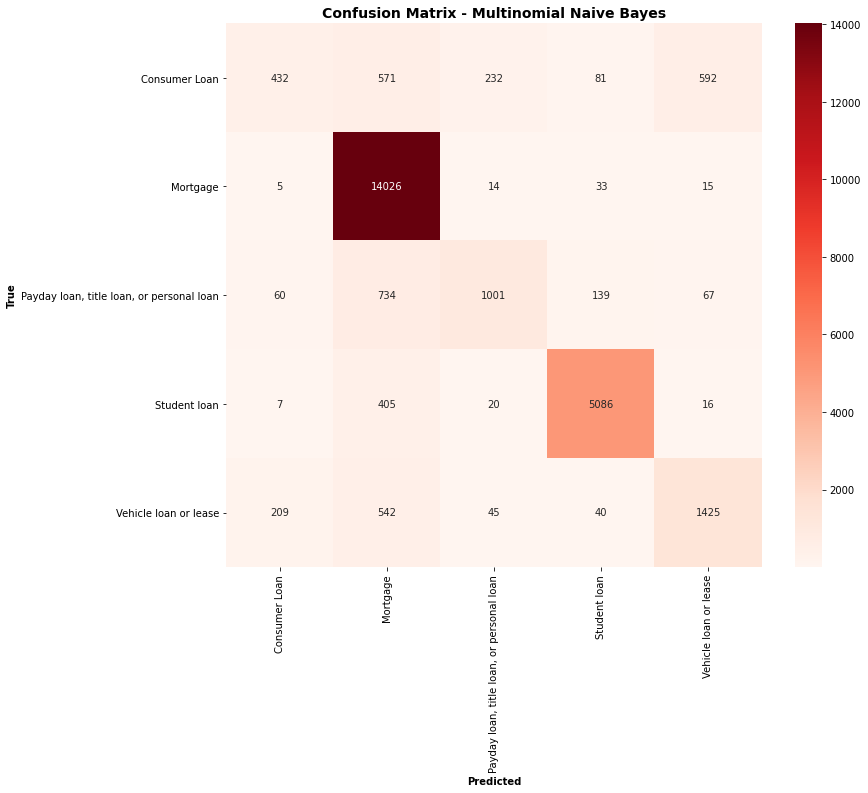

In [45]:
plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Multinomial Naive Bayes', figsize=(12, 10))

In [47]:
df_optimize.shape

(103188, 16)

In [48]:
validation_loan_data.shape

(25797, 15)

### Random forest

In [50]:
vectorizer = TfidfVectorizer(min_df=3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))

In [51]:
pipeline_rf = Pipeline(steps = [('TfIdf', vectorizer),
                              ('clf', RandomForestClassifier())])

In [52]:
model = pipeline_rf.fit(X_train, y_train)

In [53]:
with open('../../data/RandomForest.pickle', 'wb') as f:
    pickle.dump(model, f)

In [54]:
y_pred = model.predict(X_test)

In [56]:
y_pred_prob = model.predict_proba(X_test)

In [57]:
lr_probs = y_pred_prob[:,1]

In [59]:
conf_matrix_df = pd.DataFrame(data=confusion_matrix(y_test, y_pred),index=key_to_label_name,
                              columns=key_to_label_name)

In [60]:
classification_rep = classification_report(y_test, y_pred,target_names=key_to_label_name)
print(classification_rep)

                                           precision    recall  f1-score   support

                            Consumer Loan       0.59      0.07      0.13      1507
                                 Mortgage       0.82      1.00      0.90     11350
Payday loan, title loan, or personal loan       0.78      0.35      0.48      1628
                             Student loan       0.94      0.91      0.92      4369
                    Vehicle loan or lease       0.61      0.55      0.58      1784

                                 accuracy                           0.82     20638
                                macro avg       0.75      0.58      0.60     20638
                             weighted avg       0.80      0.82      0.79     20638



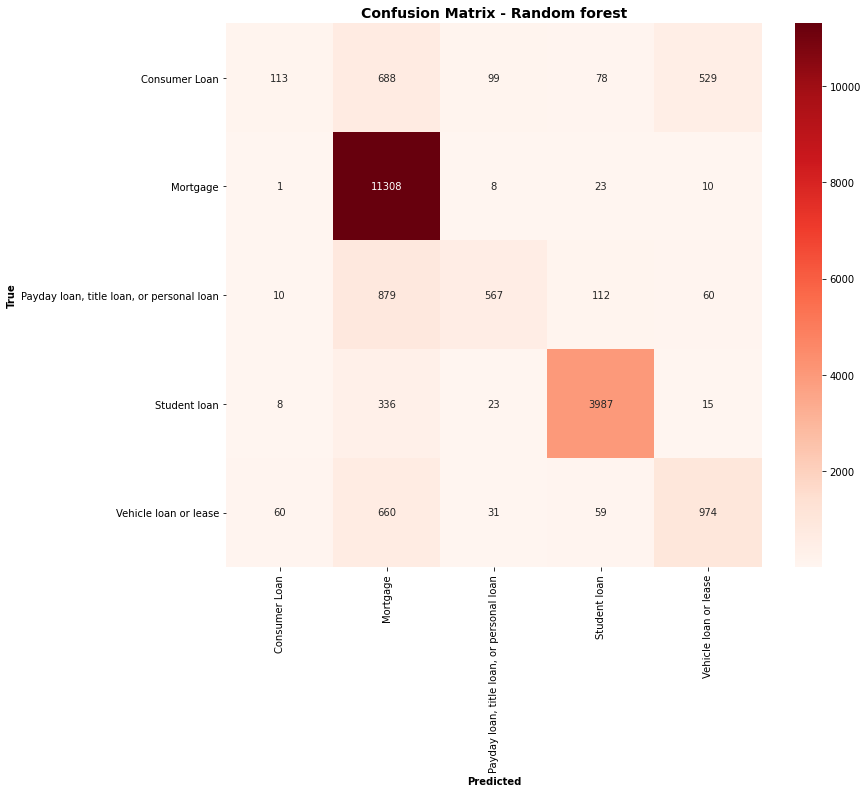

In [61]:
plotConfusionMatrixHeatmap(conf_matrix_df, model_name='Random forest', figsize=(12, 10))

In [62]:
y_predicted_val = model.predict(X_validation)

In [63]:
classification_report_mnb = classification_report(y_validation, y_predicted_val, target_names=key_to_label_name)
print(classification_report_mnb)

                                           precision    recall  f1-score   support

                            Consumer Loan       0.58      0.09      0.16      1908
                                 Mortgage       0.82      0.99      0.90     14093
Payday loan, title loan, or personal loan       0.81      0.36      0.49      2001
                             Student loan       0.94      0.92      0.93      5534
                    Vehicle loan or lease       0.64      0.57      0.61      2261

                                 accuracy                           0.83     25797
                                macro avg       0.76      0.59      0.62     25797
                             weighted avg       0.81      0.83      0.79     25797



In [4]:
tickets_df.head()

,Unnamed: 0,full_text,submitted_via,sub_label,label,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count
0,0,transworld systems inc. \nis trying to collect...,Web,I do not know,Debt collection,18,15,9,0,4.444444,98,3
1,1,Incorrect information on your report-Informati...,Web,Credit reporting,"Credit reporting, credit repair services, or o...",9,9,4,0,7.111111,72,1
2,2,"Over the past 2 weeks, I have been receiving e...",Web,I do not know,Debt collection,78,54,43,0,4.076923,395,5
3,3,Pioneer has committed several federal violatio...,Web,Other debt,Debt collection,152,96,41,0,4.611842,852,40
4,5,Problem with a credit reporting company's inve...,Web,Credit reporting,"Credit reporting, credit repair services, or o...",20,18,9,0,5.850000,136,2


In [5]:
tickets_df[tickets_df['label'] == 'Consumer Loan']

,Unnamed: 0,full_text,submitted_via,sub_label,label,word_count,unique_word_count,stop_word_count,url_count,mean_word_length,char_count,punctuation_count
330,595,"On XX/XX/2016, I received a credit monitoring ...",Web,Installment loan,Consumer Loan,114,84,47,0,4.649123,643,21
498,1057,"In XXXX XXXX, I received a loan from the XXXX ...",Web,Installment loan,Consumer Loan,287,138,140,0,4.400697,1559,29
548,1191,Financial phishing!!! Was getting XXXX hang-up...,Web,Installment loan,Consumer Loan,258,152,129,0,4.310078,1369,29
3169,10698,I had first taken out my loan with Opportunity...,Web,Installment loan,Consumer Loan,537,209,267,0,4.163873,2792,138
3211,10824,My employer made a huge error with my paycheck...,Web,Installment loan,Consumer Loan,533,267,270,0,4.525328,2950,76
